In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.style as style
plt.rcParams.update({'axes.labelsize':16})
plt.rcParams.update({'axes.titlesize':16})
plt.rcParams.update({'legend.fontsize':16})
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 4
plt.style.use('ggplot')
import os
os.chdir('../')
from data_processing import helper_functions, regression_model, plot, find_fips_for_depts
os.chdir('notebooks')
import matplotlib.dates as mdates

In [2]:
df_betas = pd.read_csv('../formatted_data/betas_baseline.csv')

In [3]:
df_betas = df_betas.rename(columns = {df_betas.columns[0]: 'department_name'})

In [4]:
df = helper_functions.clean_raw_data(pd.read_csv('../raw_data/all_depts.csv'))
df_no_gaps = df.groupby('department_name').apply(helper_functions.remove_gaps, gap_threshold=2).reset_index(drop=True)
df_no_outliers = df_no_gaps.groupby('department_name').apply(helper_functions.remove_outliers, sig=0.01).reset_index(drop=True)
df_with_dummies = helper_functions.add_dummies_to_df(df_no_outliers).sort_values(['department_name','date'])
df_with_dummies.insert(3, 'intercept', 1)

In [5]:
df_with_dummies = df_with_dummies[(df_with_dummies['year'] == 2020) & (df_with_dummies['month'] < 6) & (df_with_dummies['month'] > 1)]

In [6]:
df_with_dummies = df_with_dummies.groupby('department_name').filter(lambda x: x.name in list(df_betas['department_name']))

In [8]:
def predict(df_data, df_betas):
    regressors = ['intercept','Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday', 'Sunday', 'March', 'April', 'May']
    pred = np.exp(df_data[regressors].to_numpy() @ df_betas[regressors].to_numpy().T)
    df_data['prediction'] = pred
    df_data['change_from_baseline'] = (df_data['count']-df_data['prediction'])/df_data['prediction'] * 100
    return df_data

In [9]:
grouped_df = df_with_dummies.groupby('department_name')
predictions = grouped_df.apply(lambda x: predict(x, df_betas[df_betas['department_name'] == x.name]))
dept_idx, depts = pd.factorize(predictions['department_name'])

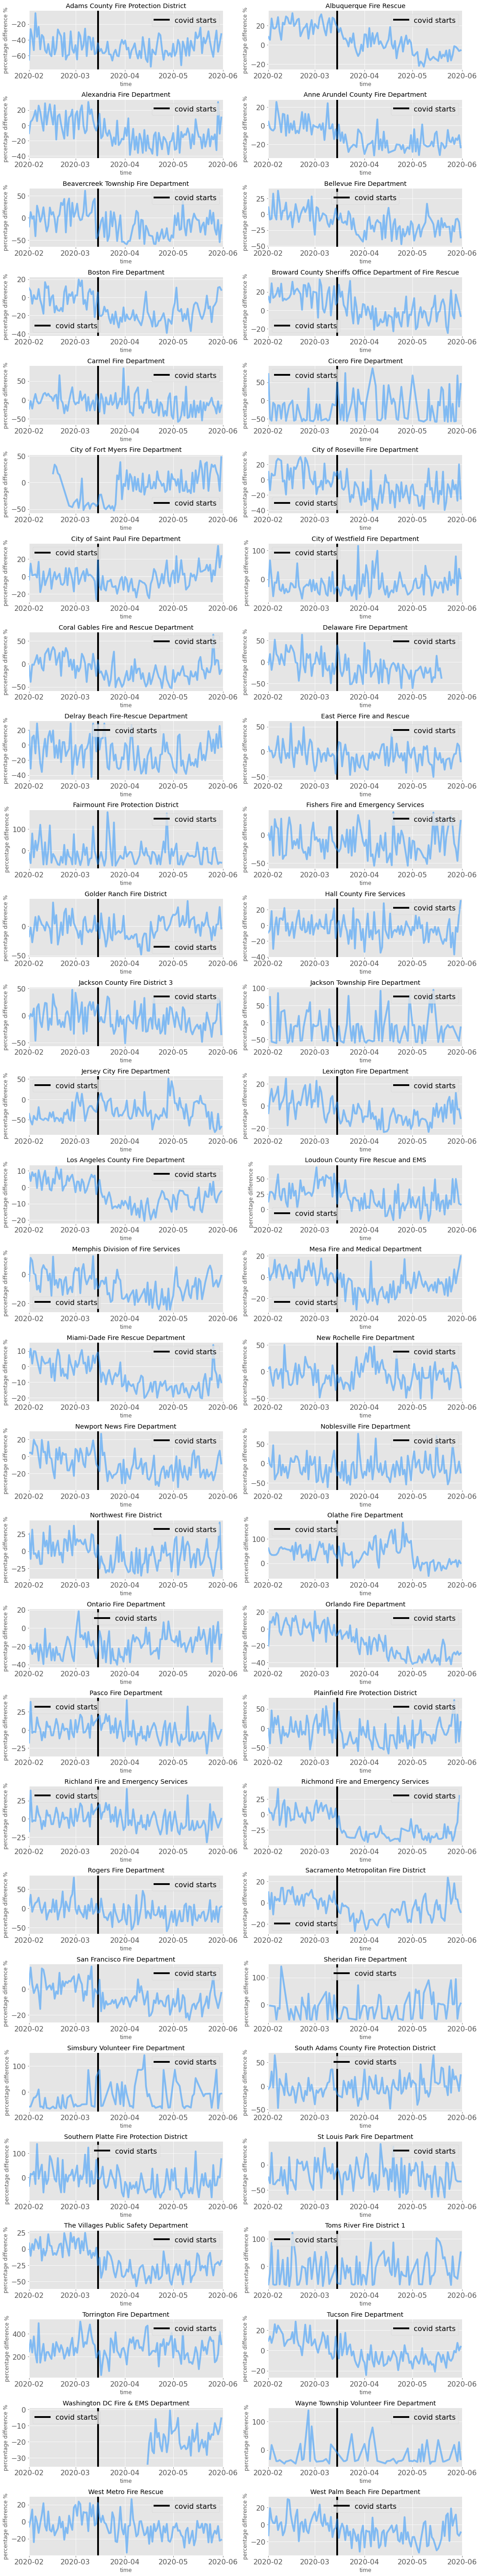

In [10]:
fig, ax = plt.subplots(nrows=29, ncols=2, figsize=(15, 80), facecolor='white')
for n, dept in enumerate(depts):
    df_dept = predictions[predictions['department_name'] == dept]
    #ax.flatten()[n].scatter(df_dept['date'], df_dept['count'], zorder=3, label='data')
    ax.flatten()[n].plot(df_dept['date'], (df_dept['count']-df_dept['prediction'])/df_dept['prediction'] * 100, zorder=3, color='dodgerblue', alpha=.5)
    ax.flatten()[n].set_xlabel('time')
    ax.flatten()[n].set_ylabel('percentage difference %')
    ax.flatten()[n].set_title(dept)
    ax.flatten()[n].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.flatten()[n].axvline(x=pd.to_datetime('2020-03-15'), color='black', label='covid starts')
    ax.flatten()[n].set_xlim(pd.to_datetime('2020-02-01'), pd.to_datetime('2020-06-01'))
    ax.flatten()[n].legend()
fig.tight_layout()
#plt.savefig(path, dpi=300, bbox_inches='tight')

In [17]:
averaged_df = predictions.groupby('department_name').apply(helper_functions.average_baseline_change_weekly).reset_index()

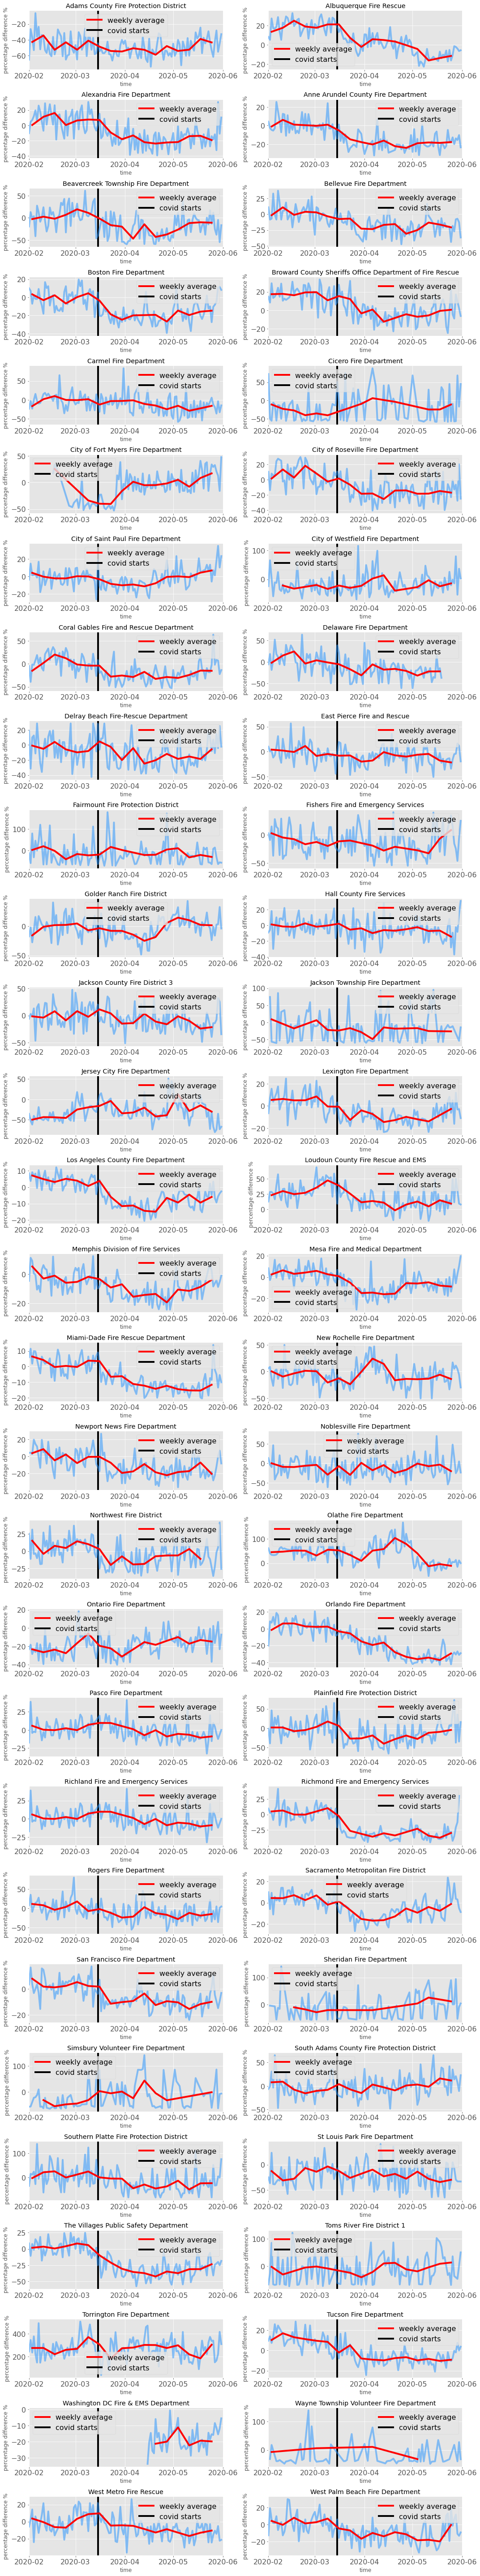

In [25]:
fig, ax = plt.subplots(nrows=29, ncols=2, figsize=(15, 80), facecolor='white')
for n, dept in enumerate(depts):
    df_dept = predictions[predictions['department_name'] == dept]
    df_avg = averaged_df[averaged_df['department_name'] == dept]
    #ax.flatten()[n].scatter(df_dept['date'], df_dept['count'], zorder=3, label='data')
    ax.flatten()[n].plot(df_dept['date'], df_dept['change_from_baseline'], zorder=3, color='dodgerblue', alpha=.5)
    ax.flatten()[n].plot(df_avg['date'], df_avg['avg_change_baseline_incidents'], zorder=3, color='red', alpha=1, label='weekly average')
    ax.flatten()[n].set_xlabel('time')
    ax.flatten()[n].set_ylabel('percentage difference %')
    ax.flatten()[n].set_title(dept)
    ax.flatten()[n].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.flatten()[n].axvline(x=pd.to_datetime('2020-03-15'), color='black', label='covid starts')
    ax.flatten()[n].set_xlim(pd.to_datetime('2020-02-01'), pd.to_datetime('2020-06-01'))
    ax.flatten()[n].legend()
fig.tight_layout()
plt.savefig('../figures/applied_baseline')

In [29]:
df_fips = find_fips_for_depts.make_fips_df(file_path='../raw_data/census_counts.csv')
df_2020_google = pd.read_csv('../raw_data/google_data/2020_US_Region_Mobility_Report.csv')
df_2020_google['date'] = pd.to_datetime(df_2020_google['date'])
df_2020_google = df_2020_google.dropna(subset='census_fips_code')
df_2020_google['county_fips_code'] = df_2020_google['census_fips_code'].astype(int)
df_2020_google = df_2020_google[['date', 'county_fips_code', 'retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline', 'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline']]
df_2020_google = df_2020_google.rename(columns={'retail_and_recreation_percent_change_from_baseline':'retail/recreation', 'grocery_and_pharmacy_percent_change_from_baseline':'grocery/pharmacy', 'parks_percent_change_from_baseline':'parks', 'workplaces_percent_change_from_baseline':'workplace', 'residential_percent_change_from_baseline':'residential'})
df_google_with_department = pd.merge(df_2020_google, df_fips, on='county_fips_code')
df_google_with_department['year'] = df_google_with_department['date'].dt.year
df_google_with_department['month'] = df_google_with_department['date'].dt.month
df_google_with_department['day_of_week'] = df_google_with_department['date'].apply(lambda x: x.day_name())
df_google_with_department = df_google_with_department.dropna()
df_google_weekly = df_google_with_department.groupby('department_name').apply(helper_functions.average_mobility_data).reset_index(level=1, drop=True).reset_index()

In [30]:
mobility_types = df_google_with_department.columns[2:7]

In [33]:
all_data = pd.merge(df_google_weekly, averaged_df, on=['date', 'department_name'], how='inner')
all_data.to_csv('../formatted_data/all_data.csv', index=False)

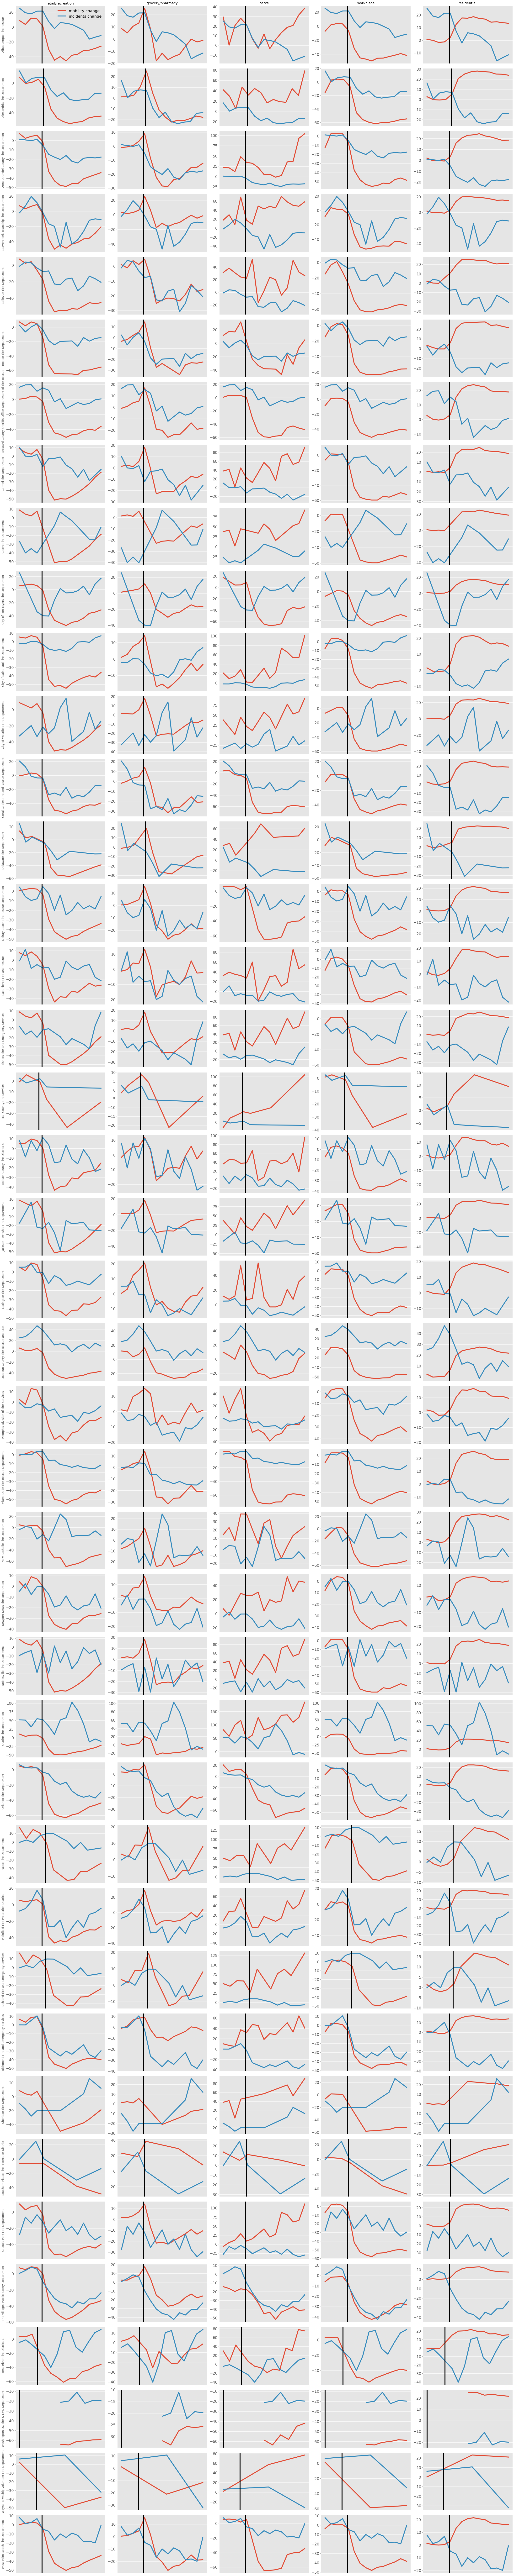

In [32]:
fig = plt.figure(figsize=(30, 150), facecolor='white')
departments = all_data['department_name'].unique()
for n, dept in enumerate(departments):
    df_dept = all_data[all_data['department_name'] == dept]
    for i, mob_type in enumerate(mobility_types):
        plt.subplot(len(departments), len(mobility_types), len(mobility_types)*n+i+1)
        plt.plot(df_dept['date'], df_dept[mob_type + '_avg'], label='mobility change')
        plt.plot(df_dept['date'], df_dept['avg_change_baseline_incidents'], label='incidents change')
        if n == 0:
            plt.title(mob_type)
            if i == 0:
                plt.legend()
        if i == 0:
            plt.ylabel(dept)
        plt.xticks([])
        plt.axvline(x=pd.to_datetime('2020-3-15'),color='black')
                
plt.tight_layout()
plt.savefig('../figures/all_data.png', facecolor=fig.get_facecolor(), dpi=300)